

---


Mount drive to work from Google drive and Colab


---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Spark and instantiate the environment variable into the Colab host

In [2]:
!ls /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"

/content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz




---


Create symbolic links to the area where the datasets are present to work with

---




In [3]:
!mkdir -p /content/data
!rm -rf /content/data/*.csv
!ln -s /content/drive/MyDrive/DE_Scale_Project/Datasets/All_cities/*.csv /content/data/



---


Spark initiatlisation


---



In [4]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()



---


Read the dataset, i.e. ALL cities Pollutant data csv file


---



In [5]:
def read_csv(path_to_file):
  return spark.read.option("delimiter", ",").csv(path_to_file, header=True, inferSchema=True)

# df_Delhi = read_csv('/content/data/City_Mumbai_wise_raw_data_1Hr_2019_2023.csv')
# df_Bengaluru = read_csv('/content/data/City_Bengaluru_wise_raw_data_1Hr_2019_2023.csv')
# df_Hyderabad = read_csv('/content/data/City_Hyderabad_wise_raw_data_1Hr_2019_2023.csv')
# df_Chennai = read_csv('/content/data/City_Chennai_wise_raw_data_1Hr_2019_2023.csv')
# df_Kolkata = read_csv('/content/data/City_Kolkata_wise_raw_data_1Hr_2019_2023.csv')
# df_Mumbai = read_csv('/content/data/City_Mumbai_wise_raw_data_1Hr_2019_2023.csv')
df_All_cities = read_csv('/content/data/City_All_wise_raw_data_1Hr_2019_2023.csv')



---


Import Spark related functions and methods


---



In [6]:
# prompt: import all spark related libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [7]:
df_All_cities.printSchema()

root
 |-- City: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- PM2.5 (µg/m³): double (nullable = true)
 |-- PM10 (µg/m³): double (nullable = true)
 |-- NO (µg/m³): double (nullable = true)
 |-- NO2 (µg/m³): double (nullable = true)
 |-- NOx (ppb): double (nullable = true)
 |-- NH3 (µg/m³): double (nullable = true)
 |-- SO2 (µg/m³): double (nullable = true)
 |-- CO (mg/m³): double (nullable = true)
 |-- Ozone (µg/m³): double (nullable = true)
 |-- Benzene (µg/m³): double (nullable = true)
 |-- Toluene (µg/m³): double (nullable = true)
 |-- Xylene (µg/m³): double (nullable = true)
 |-- O Xylene (µg/m³): double (nullable = true)
 |-- Eth-Benzene (µg/m³): double (nullable = true)
 |-- MP-Xylene (µg/m³): double (nullable = true)
 |-- AT (°C): double (nullable = true)
 |-- RH (%): double (nullable = true)
 |-- WS (m/s): double (nullable = true)
 |-- WD (deg): double (nullable = true)
 |-- RF (mm): double (nullable = true)
 |-- TOT-RF (mm): double (nullable = true)
 |-



---


1. Change the names of columns to make it easy to work in Spark enviroment.
2. Convert timestamp from string to timestamp format for later computations.
3. Then order the dataset by Cities and within each city by timestamp.


---



In [8]:
df_All_cities = df_All_cities.withColumnRenamed("PM2.5 (µg/m³)", "PM2p5")
df_All_cities = df_All_cities.withColumnRenamed("PM10 (µg/m³)", "PM10")
df_All_cities = df_All_cities.withColumnRenamed("NO (µg/m³)", "NO")
df_All_cities = df_All_cities.withColumnRenamed("NO2 (µg/m³)", "NO2")
df_All_cities = df_All_cities.withColumnRenamed("NOx (ppb)", "NOx")
df_All_cities = df_All_cities.withColumnRenamed("NH3 (µg/m³)", "NH3")
df_All_cities = df_All_cities.withColumnRenamed("CO (mg/m³)", "CO")
df_All_cities = df_All_cities.withColumnRenamed("SO2 (µg/m³)", "SO2")
df_All_cities = df_All_cities.withColumnRenamed("Ozone (µg/m³)", "Ozone")
df_All_cities = df_All_cities.withColumnRenamed("Benzene (µg/m³)", "Benzene")
df_All_cities = df_All_cities.withColumnRenamed("Toluene (µg/m³)", "Toluene")
df_All_cities = df_All_cities.withColumnRenamed("Xylene (µg/m³)", "Xylene")
df_All_cities = df_All_cities.withColumnRenamed("O Xylene (µg/m³)", "O-Xylene")
df_All_cities = df_All_cities.withColumnRenamed("Eth-Benzene (µg/m³)", "Eth-Benzene")
df_All_cities = df_All_cities.withColumnRenamed("MP-Xylene (µg/m³)" , "MP-Xylene")
df_All_cities = df_All_cities.withColumnRenamed("AT (°C)", "Temperature")
df_All_cities = df_All_cities.withColumnRenamed("RH (%)", "Humidity")
df_All_cities = df_All_cities.withColumnRenamed("WS (m/s)", "Wind_Speed")
df_All_cities = df_All_cities.withColumnRenamed("WD (deg)", "Wind_Direction")
df_All_cities = df_All_cities.withColumnRenamed("RF (mm)", "RF")
df_All_cities = df_All_cities.withColumnRenamed("TOT-RF (mm)", "TOT-RF")
df_All_cities = df_All_cities.withColumnRenamed("SR (W/mt2)", "SR")
df_All_cities = df_All_cities.withColumnRenamed("BP (mmHg)", "BP")
df_All_cities = df_All_cities.withColumnRenamed("VWS (m/s)", "VWS" )
df_All_cities = df_All_cities.withColumn("Timestamp", to_timestamp(col("Timestamp"), "M/d/yyyy H:mm"))
df_All_cities = df_All_cities.orderBy(col("city"), col("timestamp"))

In [9]:
df_All_cities.printSchema()
df_All_cities.show(5)

root
 |-- City: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- PM2p5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- Ozone: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- O-Xylene: double (nullable = true)
 |-- Eth-Benzene: double (nullable = true)
 |-- MP-Xylene: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Direction: double (nullable = true)
 |-- RF: double (nullable = true)
 |-- TOT-RF: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- BP: double (nullable = true)
 |-- VWS: double (nullable = true)

+---------



---


Calculate the percentage of missing values in each columns of the dataframe.


---



In [10]:
total_rows = df_All_cities.count()
missing_percentage_df = df_All_cities.select([(sum(when(col(c).isNull(), 1).otherwise(0)) / total_rows * 100).alias(c) for c in df_All_cities.columns])
missing_percentage_df.show()

+----+---------+-------------------+-----------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-----------------+-----------------+----------------+------------------+-----------------+-----------------+--------------------+-------------------+--------------------+------------------+------+------------------+------------------+----------------+
|City|Timestamp|              PM2p5|             PM10|                 NO|               NO2|                NOx|               NH3|                SO2|                 CO|              Ozone|            Benzene|          Toluene|           Xylene|        O-Xylene|       Eth-Benzene|        MP-Xylene|      Temperature|            Humidity|         Wind_Speed|      Wind_Direction|                RF|TOT-RF|                SR|                BP|             VWS|
+----+---------+-------------------+-----------------+------------------



---


Keep only those columns in the dataframe which have missing values less than 10% of total values in a column


---



In [11]:
threshold = 10
filtered_columns = [col for col in missing_percentage_df.columns if missing_percentage_df.select(col).first()[0] < threshold]

print(f"Columns with less than {threshold}% missing values:")
filtered_columns

Columns with less than 10% missing values:


['City',
 'Timestamp',
 'PM2p5',
 'PM10',
 'NO',
 'NO2',
 'NOx',
 'NH3',
 'SO2',
 'CO',
 'Ozone',
 'Benzene',
 'Toluene',
 'Temperature',
 'Humidity',
 'Wind_Speed',
 'Wind_Direction',
 'TOT-RF',
 'SR',
 'BP']

In [12]:
df_All_cities = df_All_cities.select([col for col in filtered_columns])
df_All_cities.filter(col("PM10").isNull()).show(5)

+---------+-------------------+--------+----+-----------+----+-----------+-----------+----+-----+-------+-----------+-----------+-----------+-----------+----------+--------------+------+--------+-----------+
|     City|          Timestamp|   PM2p5|PM10|         NO| NO2|        NOx|        NH3| SO2|   CO|  Ozone|    Benzene|    Toluene|Temperature|   Humidity|Wind_Speed|Wind_Direction|TOT-RF|      SR|         BP|
+---------+-------------------+--------+----+-----------+----+-----------+-----------+----+-----+-------+-----------+-----------+-----------+-----------+----------+--------------+------+--------+-----------+
|Bengaluru|2019-04-26 22:00:00|    NULL|NULL|       NULL|NULL|       NULL|       NULL|NULL| NULL|   NULL|       NULL|       NULL|       NULL|       NULL|      NULL|          NULL|   0.0|    NULL|       NULL|
|Bengaluru|2021-02-08 06:00:00| 41.9925|NULL|4.606666667|NULL|      35.76|10.59857143|NULL|0.634|31.1375|0.301428571|0.796666667|17.80666667|59.11444444|     0.714|    

In [13]:
df_All_cities.printSchema()

root
 |-- City: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- PM2p5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- Ozone: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Direction: double (nullable = true)
 |-- TOT-RF: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- BP: double (nullable = true)





---


Extract all the numeric columns


---



In [14]:
numeric_cols = [f.name for f in df_All_cities.schema.fields if isinstance(f.dataType, (IntegerType, FloatType, DoubleType, LongType))]
numeric_cols

['PM2p5',
 'PM10',
 'NO',
 'NO2',
 'NOx',
 'NH3',
 'SO2',
 'CO',
 'Ozone',
 'Benzene',
 'Toluene',
 'Temperature',
 'Humidity',
 'Wind_Speed',
 'Wind_Direction',
 'TOT-RF',
 'SR',
 'BP']

In [15]:
df_All_cities = df_All_cities.orderBy(col("City"), col("Timestamp"))



---


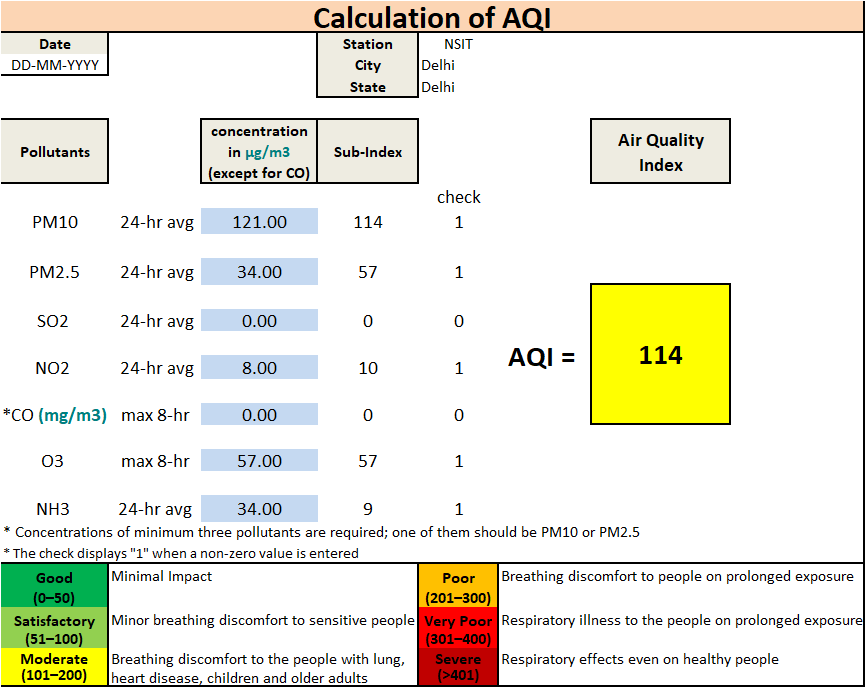

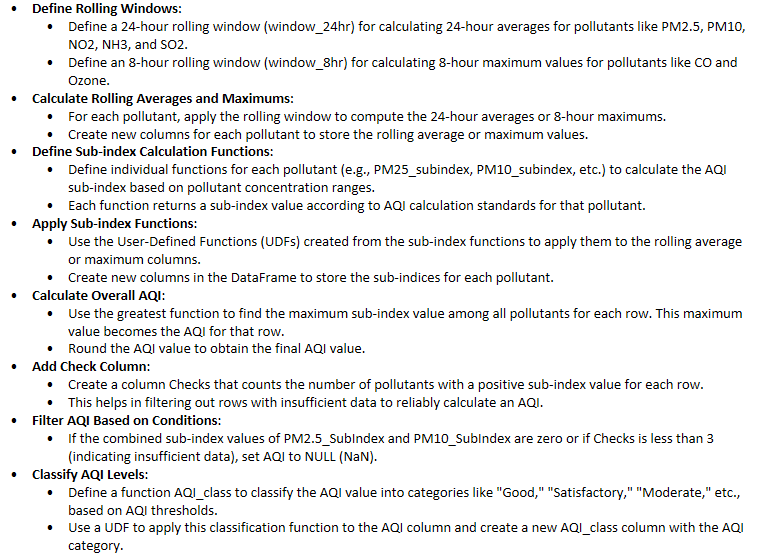



---





---


1. Define Rolling Windows
2. Calculate Rolling Averages and Maximums


---



In [16]:
# Define window specifications for each operation
window_24hr = Window.partitionBy("City").orderBy("Timestamp").rowsBetween(-23, 0)
window_8hr = Window.partitionBy("City").orderBy("Timestamp").rowsBetween(-7, 0)

# Calculate 24-hour rolling average for each specified column
df_All_cities = df_All_cities \
    .withColumn("PM2p5_24hr_avg", avg("PM2p5").over(window_24hr)) \
    .withColumn("PM10_24hr_avg", avg("PM10").over(window_24hr)) \
    .withColumn("NO2_24hr_avg", avg("NO2").over(window_24hr)) \
    .withColumn("NH3_24hr_avg", avg("NH3").over(window_24hr)) \
    .withColumn("SO2_24hr_avg", avg("SO2").over(window_24hr))

# Calculate 8-hour rolling maximum for each specified column
df_All_cities = df_All_cities \
    .withColumn("CO_8hr_max", max("CO").over(window_8hr)) \
    .withColumn("Ozone_8hr_max", max("Ozone").over(window_8hr))





---


3.  Define Sub-index Calculation Functions
4. Apply Sub-index Functions


---



In [17]:
def PM25_subindex(x):
  if x is not None:
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return None
  else:
    return None

PM25_subindex_udf = udf(PM25_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("PM2p5_SubIndex", PM25_subindex_udf("PM2p5_24hr_avg"))


def PM10_subindex(x):
  if x is not None:
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return None
  else:
    return None

PM10_subindex_udf = udf(PM10_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("PM10_SubIndex", PM10_subindex_udf("PM10_24hr_avg"))


def SO2_subindex(x):
  if x is not None:
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return None
  else:
    return None

SO2_subindex_udf = udf(SO2_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("SO2_SubIndex", SO2_subindex_udf("SO2_24hr_avg"))


def NO2_subindex(x):
  if x is not None:
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return None
  else:
    return None

NO2_subindex_udf = udf(NO2_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("NO2_SubIndex", NO2_subindex_udf("NO2_24hr_avg"))


def NH3_subindex(x):
  if x is not None:
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return None
  else:
    return None

NH3_subindex_udf = udf(NH3_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("NH3_SubIndex", NH3_subindex_udf("NH3_24hr_avg"))


def CO_subindex(x):
  if x is not None:
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return None
  else:
    return None

CO_subindex_udf = udf(CO_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("CO_SubIndex", CO_subindex_udf("CO_8hr_max"))


def O3_subindex(x):
  if x is not None:
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return None
  else:
    return None

O3_subindex_udf = udf(O3_subindex, DoubleType())
df_All_cities = df_All_cities.withColumn("Ozone_SubIndex", O3_subindex_udf("Ozone_8hr_max"))





---


5. Add Check Column
6. Calculate Overall AQI
7. Filter AQI Based on Conditions
8. Classify AQI Levels


---



In [18]:
df_All_cities = df_All_cities.withColumn(
    "Checks",
    (when(col("PM2p5_SubIndex") > 0, 1).otherwise(0) +
     when(col("PM10_SubIndex") > 0, 1).otherwise(0) +
     when(col("SO2_SubIndex") > 0, 1).otherwise(0) +
     when(col("NO2_SubIndex") > 0, 1).otherwise(0) +
     when(col("NH3_SubIndex") > 0, 1).otherwise(0) +
     when(col("CO_SubIndex") > 0, 1).otherwise(0) +
     when(col("Ozone_SubIndex") > 0, 1).otherwise(0))
)
df_All_cities = df_All_cities.withColumn("AQI" , round(greatest("PM2p5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NO2_SubIndex", "NH3_SubIndex", "CO_SubIndex", "Ozone_SubIndex")))

df_All_cities = df_All_cities.withColumn("AQI",when((col("PM2p5_SubIndex") + col("PM10_SubIndex") <= 0) | (col("Checks") < 3), None).otherwise(col("AQI")))

def AQI_class(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return None

AQI_class_udf = udf(AQI_class, StringType())
df_All_cities = df_All_cities.withColumn("AQI_class", AQI_class_udf("AQI"))

In [19]:
# Show the resulting DataFrame
df_All_cities.filter(col("City") == "Chennai").show(10)

+-------+-------------------+-----------+----+-----------+-----------+-----------+-----+-----------+-----------+------+-------+-------+-----------+-----------+-----------+--------------+------+------+-----------+------------------+-------------+------------------+------------------+------------------+-----------+-------------+------------------+-------------+------------------+------------------+------------------+------------------+--------------+------+-----+------------+
|   City|          Timestamp|      PM2p5|PM10|         NO|        NO2|        NOx|  NH3|        SO2|         CO| Ozone|Benzene|Toluene|Temperature|   Humidity| Wind_Speed|Wind_Direction|TOT-RF|    SR|         BP|    PM2p5_24hr_avg|PM10_24hr_avg|      NO2_24hr_avg|      NH3_24hr_avg|      SO2_24hr_avg| CO_8hr_max|Ozone_8hr_max|    PM2p5_SubIndex|PM10_SubIndex|      SO2_SubIndex|      NO2_SubIndex|      NH3_SubIndex|       CO_SubIndex|Ozone_SubIndex|Checks|  AQI|   AQI_class|
+-------+-------------------+-----------+-



---


 Replace the NULL values in each numeric column with 0


---



In [20]:
numeric_cols

['PM2p5',
 'PM10',
 'NO',
 'NO2',
 'NOx',
 'NH3',
 'SO2',
 'CO',
 'Ozone',
 'Benzene',
 'Toluene',
 'Temperature',
 'Humidity',
 'Wind_Speed',
 'Wind_Direction',
 'TOT-RF',
 'SR',
 'BP']

In [21]:
df_All_cities = df_All_cities.fillna(0, subset=numeric_cols)



---


Check the percentage of missing values in all the numeric columns. It should be all 0


---



In [22]:
total_rows = df_All_cities.count()
missing_percentage_df = df_All_cities.select([(sum(when(col(c).isNull(), 1).otherwise(0)) / total_rows * 100).alias(c) for c in df_All_cities.columns])
missing_percentage_df.show()

+----+---------+-----+----+---+---+---+---+---+---+-----+-------+-------+-----------+--------+----------+--------------+------+---+---+--------------+------------------+-------------------+------------------+--------------------+----------+--------------------+--------------+------------------+--------------------+-------------------+------------------+-----------+--------------------+------+---+---------+
|City|Timestamp|PM2p5|PM10| NO|NO2|NOx|NH3|SO2| CO|Ozone|Benzene|Toluene|Temperature|Humidity|Wind_Speed|Wind_Direction|TOT-RF| SR| BP|PM2p5_24hr_avg|     PM10_24hr_avg|       NO2_24hr_avg|      NH3_24hr_avg|        SO2_24hr_avg|CO_8hr_max|       Ozone_8hr_max|PM2p5_SubIndex|     PM10_SubIndex|        SO2_SubIndex|       NO2_SubIndex|      NH3_SubIndex|CO_SubIndex|      Ozone_SubIndex|Checks|AQI|AQI_class|
+----+---------+-----+----+---+---+---+---+---+---+-----+-------+-------+-----------+--------+----------+--------------+------+---+---+--------------+------------------+-----------



---


Add the following features to the dataframe.
1. Vehicular Pollution
2. Industrial Pollution


---



In [23]:
df_All_cities = df_All_cities.withColumn("Vehicular_Pollution", col("PM2p5") + col("PM10") + col("NO") + col("NO2") + col("NOx") + col("NH3") + col("CO"))
df_All_cities = df_All_cities.withColumn("Industrial_Pollution", col("SO2") + col("Ozone") + col("Benzene"))

In [24]:
# Filter for years 2019 to 2022
df_All_cities_2019_2022 = df_All_cities.filter((year("Timestamp") >= 2019) & (year("Timestamp") <= 2022))

# Filter for the year 2023
df_All_cities_2023 = df_All_cities.filter(year("Timestamp") == 2023)

In [25]:
df_All_cities.printSchema()
df_All_cities_2019_2022.show(5)
df_All_cities_2023.show(5)

root
 |-- City: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- PM2p5: double (nullable = false)
 |-- PM10: double (nullable = false)
 |-- NO: double (nullable = false)
 |-- NO2: double (nullable = false)
 |-- NOx: double (nullable = false)
 |-- NH3: double (nullable = false)
 |-- SO2: double (nullable = false)
 |-- CO: double (nullable = false)
 |-- Ozone: double (nullable = false)
 |-- Benzene: double (nullable = false)
 |-- Toluene: double (nullable = false)
 |-- Temperature: double (nullable = false)
 |-- Humidity: double (nullable = false)
 |-- Wind_Speed: double (nullable = false)
 |-- Wind_Direction: double (nullable = false)
 |-- TOT-RF: double (nullable = false)
 |-- SR: double (nullable = false)
 |-- BP: double (nullable = false)
 |-- PM2p5_24hr_avg: double (nullable = true)
 |-- PM10_24hr_avg: double (nullable = true)
 |-- NO2_24hr_avg: double (nullable = true)
 |-- NH3_24hr_avg: double (nullable = true)
 |-- SO2_24hr_avg: double (nullable = true)
 



---


**Distribution of pollutants across different cities.**

The intention is to understand the distribution of major pollutants across the cities that we are studing. This analysis will help us to understand the distribution of pollutant values and compare it with other cities


---



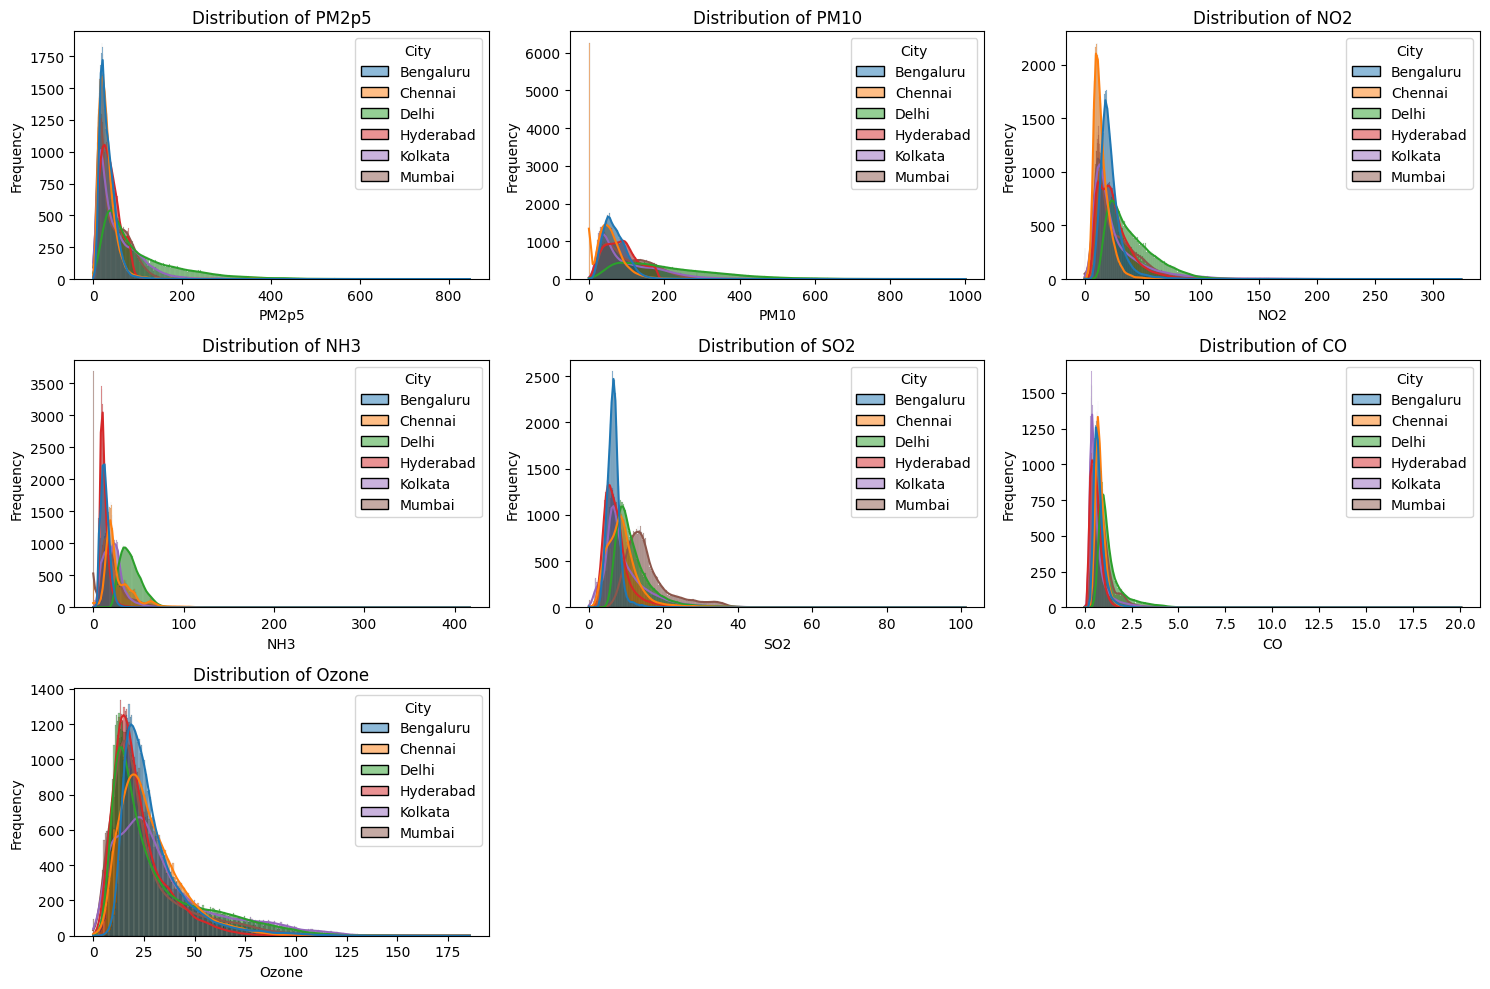

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

pandas_df = df_All_cities.toPandas()
pollutants = ['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']


plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=pandas_df, x=pollutant, hue='City', kde=True)
    plt.title(f'Distribution of {pollutant}')
    plt.xlabel(pollutant)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Insights:

Airborne particulate matter (PM) : Bangalore and Chennai has most of their samples under 100 and 200 for PM2.5 and PM10 respectively. Delhi has a more flatter distribution with higher number of samples having high values for PM pollutants.

Ozone and CO: All the cities are showing an identical trend w.r.t Ozone.

SO2 - Bangalore has most of the samples showing values in the range 0-10. Mumbai shows higher values for SO2 while the samples for other cities shows a sinusoidal curve between 0 and 30.

Among all the pollutants, Delhi shows a trend of flatter sinusoidal curves with highest pollutant levels than other cities for all pollutants other than SO2.




---


**Average value of major pollutants for each city.**

This plot will help us visualize the major pollutants for each city and compare the average value of each pollutant across the cities under study.

---



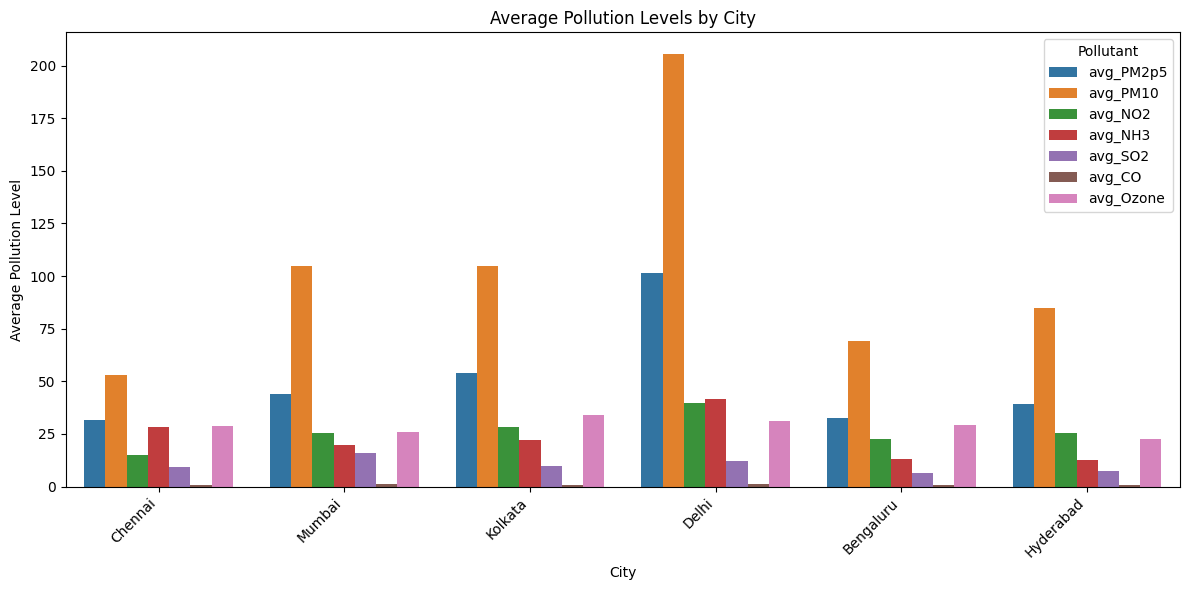

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


pollutants = ['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
avg_pollution_by_city = df_All_cities.groupBy("City").agg(
    *[avg(col).alias(f"avg_{col}") for col in pollutants]
)


pandas_df = avg_pollution_by_city.toPandas()


melted_df = pandas_df.melt(
    id_vars="City", var_name="Pollutant", value_name="Average Level"
)


plt.figure(figsize=(12, 6))
sns.barplot(x="City", y="Average Level", hue="Pollutant", data=melted_df)
plt.title("Average Pollution Levels by City")
plt.xlabel("City")
plt.ylabel("Average Pollution Level")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Insights:**

For all the cities the major air pollution comes from "Airborne particulate matter (PM)".
Delhi and Mumbai has higher values for almost all pollutants.
Level of pollutants across Cities for the duration 2019 - 2024
The intention is to compare the levels of pollutants across cities for the years 2019 - 2024.



---


**Interactive plot of monthly average levels of different pollutants**

The intention is to identify the seasonal change of pollutant values across cities and identify the months where a particular pollutant level reaches their peak.


---



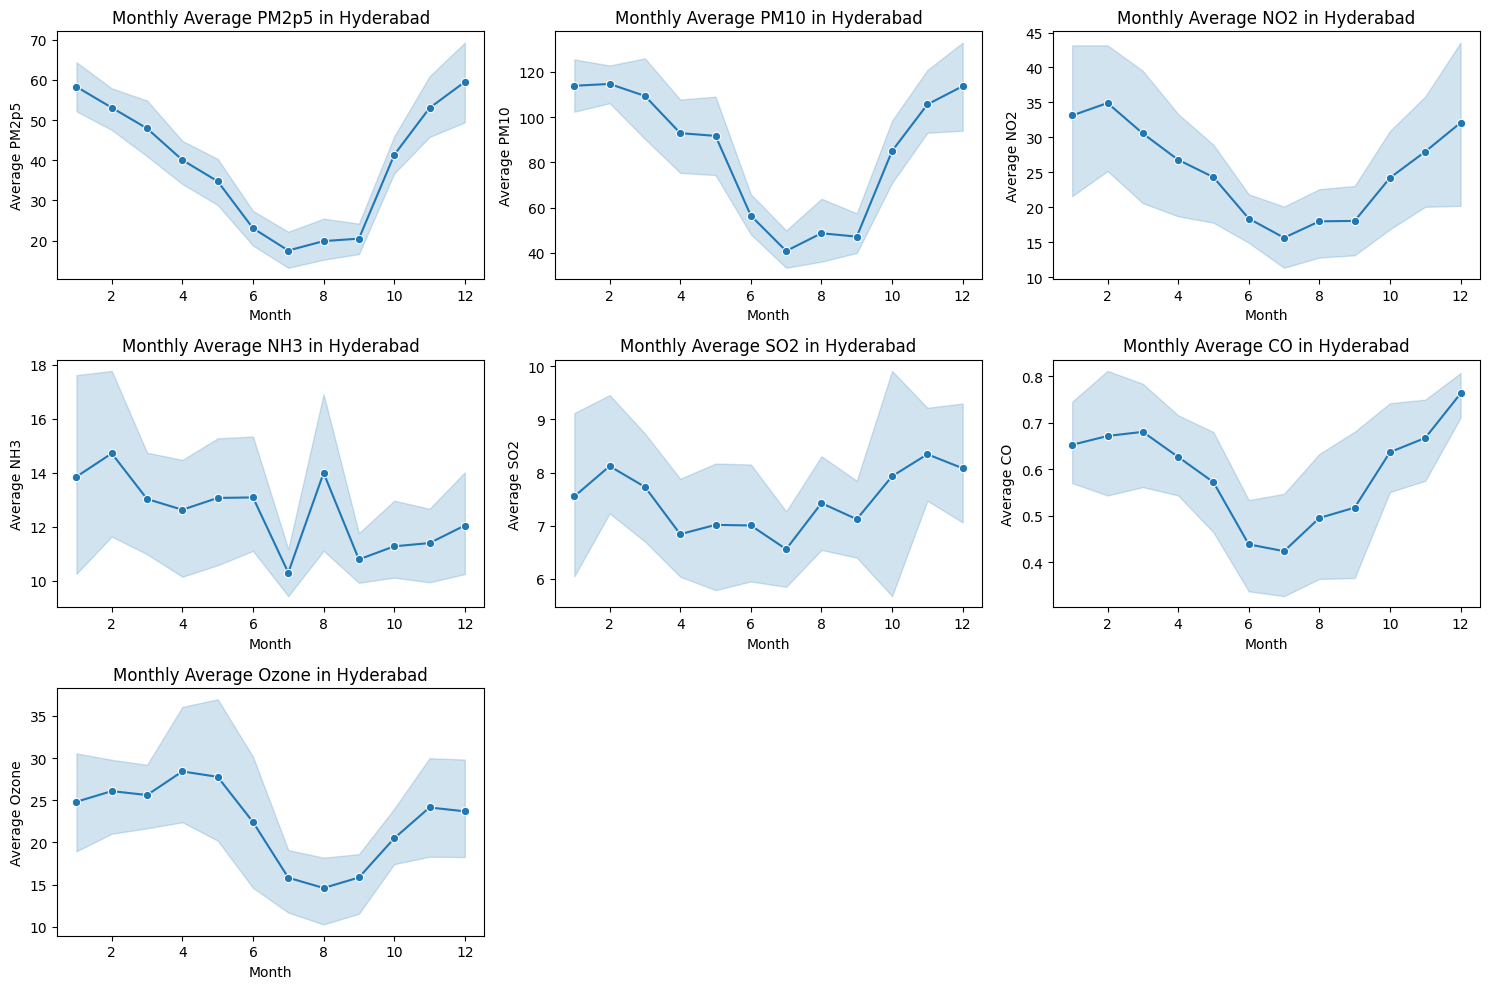

In [37]:
from pyspark.sql.functions import month, year

pollutants = ['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
city_name = "Hyderabad" #@param ["Bengaluru", "Chennai", "Delhi", "Hyderabad", "Kolkata", "Mumbai"]

monthly_avg_pollution = df_All_cities.filter(col("City") == city_name).groupBy(year("Timestamp").alias("Year"), month("Timestamp").alias("Month")).agg(
    *[avg(col).alias(f"avg_{col}") for col in pollutants]
)


import pandas as pd
pandas_df = monthly_avg_pollution.toPandas()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

for i, pollutant in enumerate(pollutants):
  plt.subplot(3,3, i+1)
  sns.lineplot(x="Month", y=f"avg_{pollutant}", data=pandas_df, marker='o')
  plt.title(f'Monthly Average {pollutant} in {city_name}')
  plt.xlabel('Month')
  plt.ylabel(f'Average {pollutant}')

plt.tight_layout()
plt.show()

**Insights**

PM pollutants show higher levels in the winter months and lower during the rains.
The values for NH3 and SO2 goes highest during the summer months.



---


Study Correlation of different pollutants  on AQI value.

---



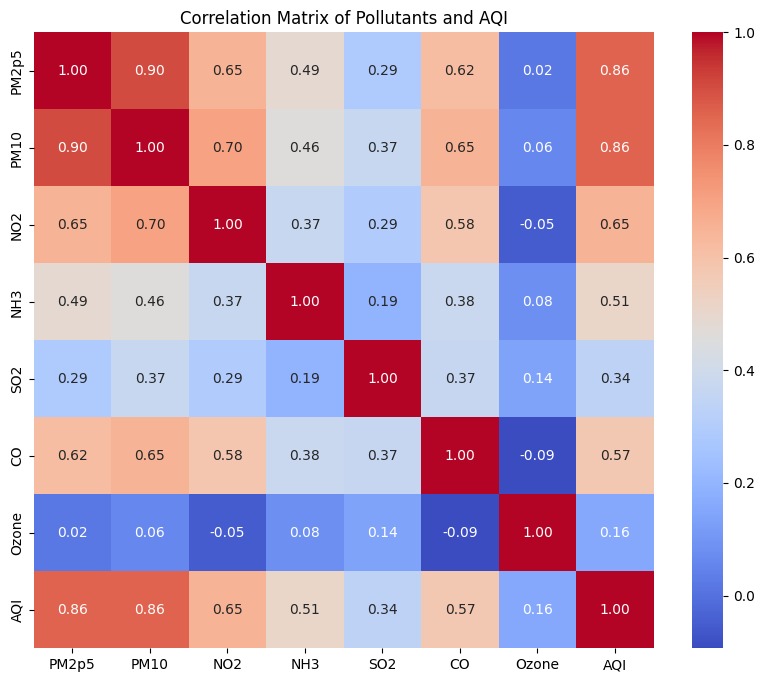

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns


pandas_df = df_All_cities.toPandas()


correlation_matrix = pandas_df[['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone', 'AQI']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pollutants and AQI')
plt.show()

**Insights:**

AQI Correlations: The Air Quality Index (AQI) has strong positive correlations (above 0.8) with PM2.5 and PM10, indicating that these particulate matter pollutants are major contributors to the overall air quality index. The correlations with other pollutants are more moderate, suggesting AQI is influenced by a combination of different pollutants.



---


Discover the monthly AQI_class distribution for different cities.

---




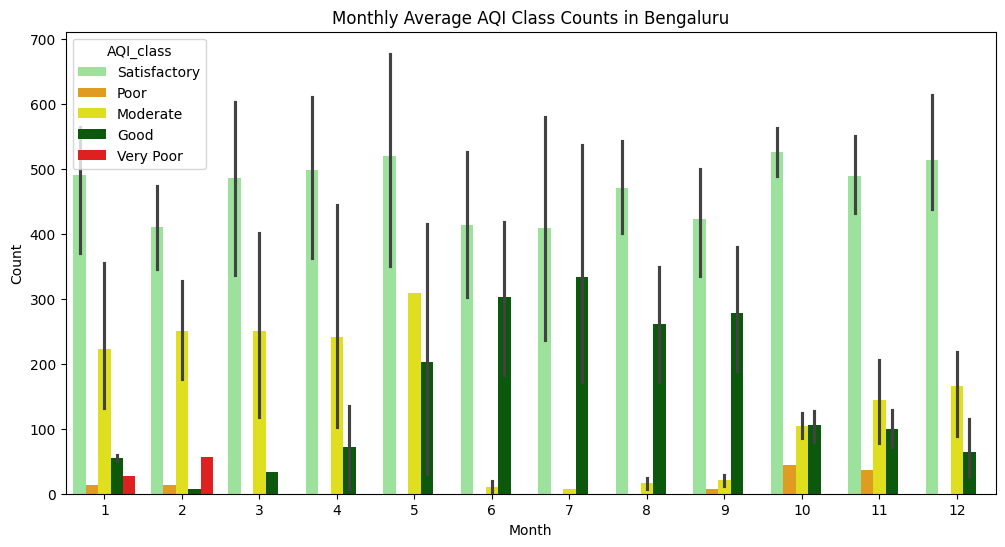

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

aqi_color_map = {
        'Good': 'darkgreen',
        'Satisfactory': 'lightgreen',
        'Moderate': 'yellow',
        'Poor': 'orange',
        'Very Poor': 'red',
        'Severe': 'darkred'
    }

city_name = "Bengaluru"  #@param ["Bengaluru", "Chennai", "Delhi", "Hyderabad", "Kolkata", "Mumbai"]

monthly_aqi_class_counts = df_All_cities.filter(col("City") == city_name) \
    .groupBy(year("Timestamp").alias("Year"), month("Timestamp").alias("Month"), "AQI_class") \
    .count()



pandas_df = monthly_aqi_class_counts.toPandas()


plt.figure(figsize=(12, 6))
sns.barplot(x="Month", y="count", hue="AQI_class", data=pandas_df, palette=aqi_color_map)
plt.title(f'Monthly Average AQI Class Counts in {city_name}')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

**Insights**

1. As we can see Bengaluru AQI is satisfactory throughout the year with moderate to poor AQI seen only in the winter months.
2. We can select the city of our choice from the drop down menu and see the monthly AQI_class distribution
3. Delhi reports the worst AQI values.
4. Bangalore and Chennai maintains large propotion of healthy AQI.




---


Discover the monthly average AQI across all cities


---



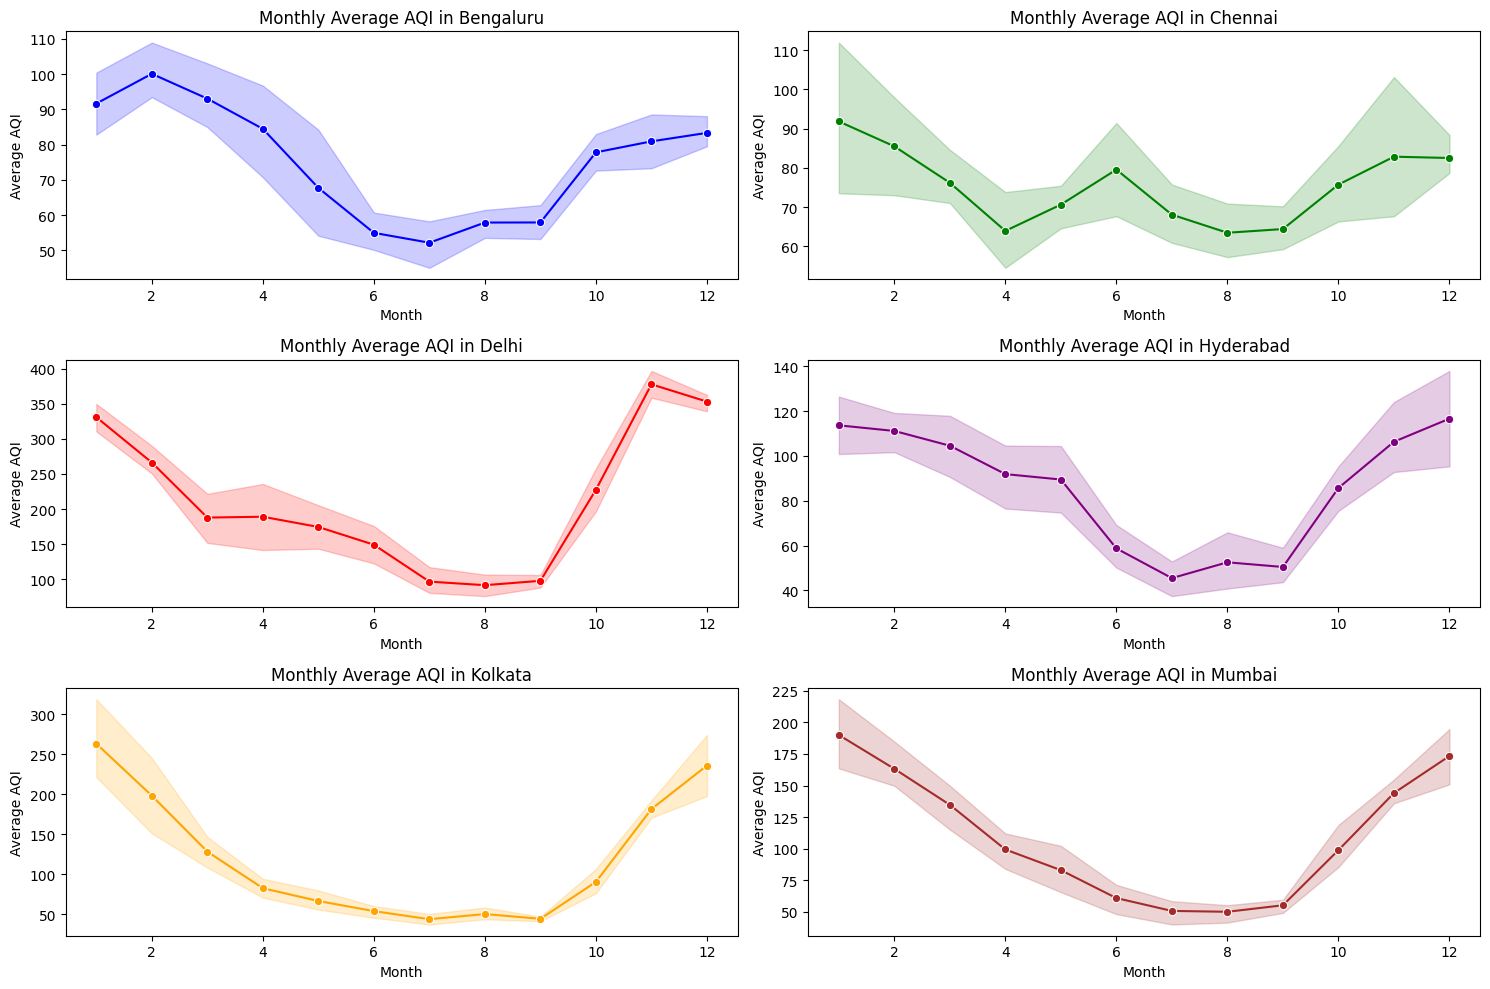

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns



cities = ["Bengaluru", "Chennai", "Delhi", "Hyderabad", "Kolkata", "Mumbai"]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

plt.figure(figsize=(15, 10))

for i, city in enumerate(cities):
    monthly_avg_aqi = df_All_cities.filter(col("City") == city).groupBy(year("Timestamp").alias("Year"), month("Timestamp").alias("Month")).agg(
        avg("AQI").alias("avg_AQI")
    )
    pandas_df = monthly_avg_aqi.toPandas()

    plt.subplot(3, 2, i + 1)
    sns.lineplot(x="Month", y="avg_AQI", data=pandas_df, marker='o', color=colors[i])
    plt.title(f'Monthly Average AQI in {city}')
    plt.xlabel('Month')
    plt.ylabel('Average AQI')

plt.tight_layout()
plt.show()

**Insights**

1. AQI for Delhi worsens significantly in the winter months.

2. All the cities except Delhi maintains a healthy AQI in the months June to September.



---


Line plot showing the average Air Quality Index (AQI) trends by city from 2019 to 2023


---



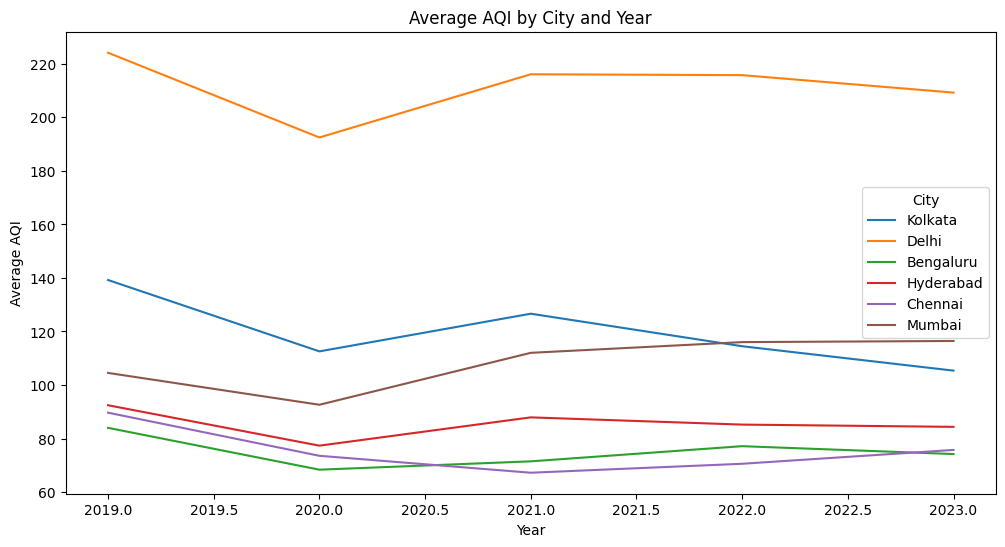

In [30]:
aqi_by_city_year = df_All_cities.groupBy("City", year("Timestamp").alias("Year")).agg(avg("AQI").alias("Avg_AQI"))


aqi_by_city_year_pandas = aqi_by_city_year.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x="Year", y="Avg_AQI", hue="City", data=aqi_by_city_year_pandas)
plt.title("Average AQI by City and Year")
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.show()

**General Drop in AQI in 2020:**

All cities experienced a noticeable dip in AQI in 2020, likely due to COVID-19 lockdown measures, which reduced industrial activity, vehicular traffic, and emissions.
For instance, cities like Delhi and Kolkata, which generally have higher AQI levels, saw significant reductions.

**Delhi's Recovery to Pre-2020 Levels:**

Delhi still had the highest AQI levels throughout the timeline, but the reduction in 2020 was substantial. Post-2020, AQI levels began increasing again but stabilized lower than 2019.

**Bangalore and Chennai's Stability:**

Bengaluru and Chennai consistently recorded the lowest AQI levels among the six cities. The decrease in 2020 was less dramatic compared to cities like Delhi or Kolkata, indicating possibly better baseline air quality or fewer high-emission sources.

**Mumbai's Gradual Increase After 2020:**

Mumbai saw a recovery in AQI after 2020, with values slowly increasing over time. This indicates a gradual return to higher pollution levels as activities resumed post-lockdown.

**Sustained Improvement in Kolkata:**

While Kolkata's AQI dropped significantly in 2020, it continued to decline over the years, indicating potential improvements in air quality or mitigation efforts



---


This bar chart compares vehicular and industrial pollution across six cities.


---



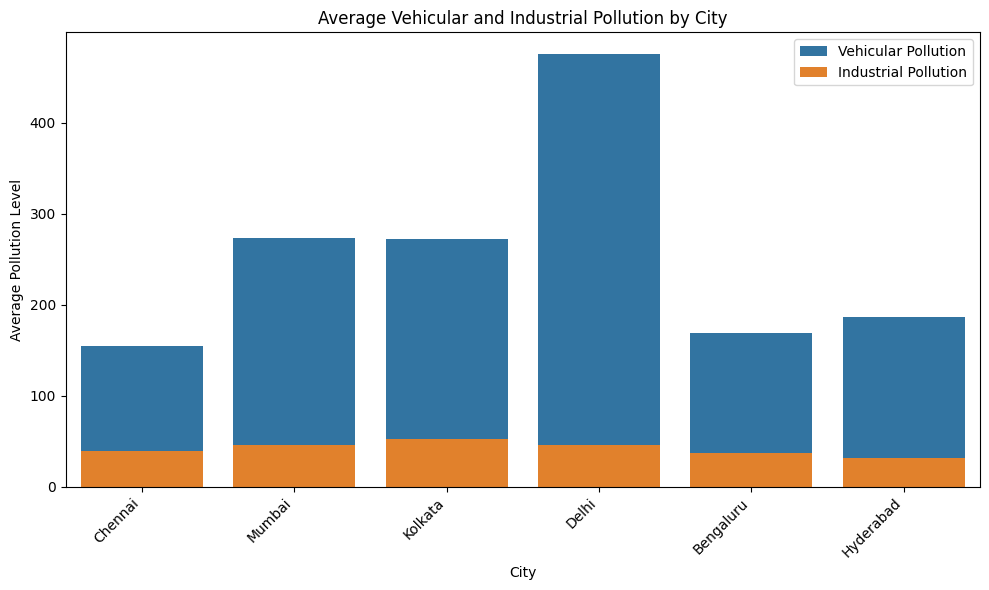

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns


city_pollution_avg = df_All_cities.groupBy("City").agg(
    avg("Vehicular_Pollution").alias("Avg_Vehicular_Pollution"),
    avg("Industrial_Pollution").alias("Avg_Industrial_Pollution")
)


pandas_df = city_pollution_avg.toPandas()


plt.figure(figsize=(10, 6))
sns.barplot(x="City", y="Avg_Vehicular_Pollution", data=pandas_df, label="Vehicular Pollution")
sns.barplot(x="City", y="Avg_Industrial_Pollution", data=pandas_df, label="Industrial Pollution")
plt.title("Average Vehicular and Industrial Pollution by City")
plt.xlabel("City")
plt.ylabel("Average Pollution Level")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

**Dominance of Vehicular Pollution:**

In all cities, vehicular pollution contributes significantly more to overall pollution levels compared to industrial pollution, highlighting transportation as a major pollution source.

**Delhi's Alarming Levels:**

Delhi stands out with the highest pollution levels, driven by vehicular emissions that far exceed other cities, underscoring the city's critical need for interventions in traffic and transportation management.





